## Importing the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constants
DATASET_DIR = './data/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd

X = pd.read_csv(os.path.join(DATASET_DIR, '/content/drive/MyDrive/Automated-Essay--Scoring-master/data/training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])

In [ ]:
X.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


Minimum and Maximum Scores for each essay set.

In [ ]:
minimum_scores = [-1, 2, 1, 0, 0, 0, 0, 0, 0]
maximum_scores = [-1, 12, 6, 3, 3, 4, 4, 30, 60]

## Preprocessing the Data

We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [ ]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences


def makeFeatureVec(words, model, num_features):
    """
    Function to average all of the word vectors in a given paragraph
    """
    featureVec = np.zeros((num_features,), dtype="float32")
    num_words = 0.
    for word in words:
        if word in model:
            num_words += 1
            featureVec = np.add(featureVec, model[word])
    if num_words != 0:
        featureVec = np.divide(featureVec, num_words)
    return featureVec


def getAvgFeatureVecs(clean_train_essays, model, num_features):
    """
    Main function to generate the word vectors for word2vec model.
    """
    essayFeatureVecs = []
    for essay in clean_train_essays:
        essayFeatureVecs.append(makeFeatureVec(essay, model, num_features))  # Pass 'model' directly
    return np.array(essayFeatureVecs)




In [ ]:
import nltk
nltk.download('punkt')

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Defining the model

Here we define a 2-Layer LSTM Model.

Note that instead of using sigmoid activation in the output layer we will use
Relu since we are not normalising training labels.

In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [ ]:
pip install --upgrade gensim

In [ ]:
from gensim.models import Word2Vec

## Training Phase

Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold.
We will then calculate Average Kappa for all the folds.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
import gensim.downloader as api  # Import for pre-trained Word2Vec model (optional)

# Define num_features
num_features = 300  # Assuming you're using a 300-dimensional Word2Vec model

cv = KFold(n_splits=5, shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n-------- Fold {} --------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]

    train_essays = X_train['essay']
    test_essays = X_test['essay']

    sentences = []

    for essay in train_essays:
        # Obtaining all sentences from the training essays.
        sentences += essay_to_sentences(essay, remove_stopwords=True)



    model = api.load("word2vec-google-news-300")  # Example: Load Google News Word2Vec (300 dimensions)

    clean_train_essays = []

    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))

    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))

    testDataVecs = getAvgFeatureVecs(clean_test_essays, model, num_features)

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)

    # Reshaping train and test vectors to 3 dimensions. (1 represents one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=5)
    # lstm_model.load_weights('./model_weights/final_lstm.h5')  # Commented out for now

    y_pred = lstm_model.predict(testDataVecs)

    # Save any one of the 5 models.
    if count == 5:
        lstm_model.save('./model_weights/final_lstm.h5')

    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)

    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)

    count += 1



-------- Fold 1 --------

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 814705 (3.11 MB)
Trainable params: 814705 (3.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
163/163 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9251


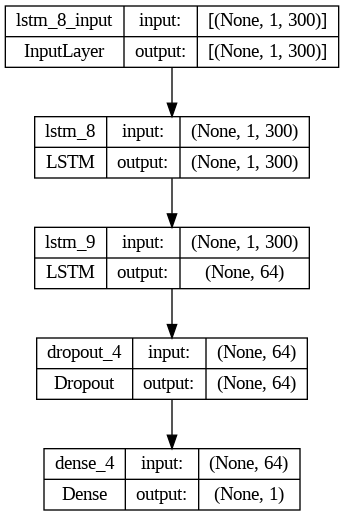

In [ ]:
# prompt: a code that creates diagram of LSTM network

from keras.utils import plot_model
from IPython.display import Image

# Assuming 'lstm_model' is your trained LSTM model
plot_model(lstm_model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image(filename='model.png')
